# Прогнозирование оттока посетителей фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

<b> План исследования: </b> <p>
* Шаг 1.Загрузка и предобработка данных <p>
* Шаг 2.Исследовательский анализ данных (EDA)
    - Есть ли в датасете отсутствующие признаки, изучить средние значения и стандартные отклонения (пригодится метод describe());
    - Посмотреть на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());
    - Построить столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
    - Построить матрицу корреляций и отобразить её <p>
* Шаг 3. Построить модель прогнозирования оттока клиентов:
    - Построить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
разбить данные на обучающую и валидационную выборку функцией train_test_split().
    - Обучить модель на train-выборке двумя способами:
        * логистической регрессией,
        * случайным лесом.
    - Оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнить по ним модели. Какая модель показала себя лучше на основании метрик? Указать параметр random_state при разделении выборки и задании алгоритма.
* Шаг 4. Сделаем кластеризацию клиентов:
    - Стандартизируем данные.
    - Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
    - Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. 
    - Построим распределения признаков для кластеров.
    - Для каждого полученного кластера посчитаем долю оттока
* Шаг 4. Выводы


    

## Загрузка и предобработка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
fitness = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#посмотрим на данные
display(fitness.head(10))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. 
Набор данных включает следующие поля:
- <b> 'Churn' </b> — факт оттока в текущем месяце;

Данные клиента за предыдущий до проверки факта оттока месяц:
- <b> 'gender'</b> — пол;
- <b> 'Near_Location'</b> — проживание или работа в районе, где находится фитнес-центр;
- <b> 'Partner' </b> — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- <b> Promo_friends </b> — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- <b> 'Phone' </b> — наличие контактного телефона;
- <b> 'Age' </b> — возраст;
- <b> 'Lifetime' </b> — время с момента первого обращения в фитнес-центр (в месяцах). 

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- <b> 'Contract_period' </b> — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- <b> 'Month_to_end_contract' </b> — срок до окончания текущего действующего абонемента (в месяцах);
- <b> 'Group_visits' </b> — факт посещения групповых занятий;
- <b> 'Avg_class_frequency_total' </b> — средняя частота посещений в неделю за все время с начала действия абонемента;
- <b> 'Avg_class_frequency_current_month' </b> — средняя частота посещений в неделю за предыдущий месяц;
- <b> 'Avg_additional_charges_total'</b> — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.    

In [4]:
#приведем названия столбцов к нижнему регистру
fitness.columns = fitness.columns.str.lower()

In [5]:
#посмотрим информацию о датафрейме
fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [6]:
fitness.duplicated().sum()

0

Пропусков не обнаружено, дубликатов не обнаружено

## Исследовательский анализ данных (EDA)

### Есть ли в датасете отсутствующие признаки, изучить средние значения и стандартные отклонения (пригодится метод describe());

In [7]:
fitness.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


<b>Что мы видим из описания датасета: </b> <p>
- пол клиентов фитнесклуба распределен примерно пополам, т.е. примерно 50% клиентов женщины и столько же мужчин
- примерно 85% посетителей живет рядом с фитнес клубом
- примерно половина клиентов клуба является сотрудником компании-партнера
- 30% от всех посетителей пришли в клуб по акции "Приведи друга"
- 90% посетителей оставили свой контактный телефон. 
- средняя длительность абонемента - 4,6 месяцев, при этом клуб продает абонимент от 1 до 12 месяцев
- групповые занятия посещает в среднем 41% клиентов
- средний возраст клиента - 29 лет, минимальный вовзраст клиента в клбуе - 18 лет, максимальный - 41 год.
- средняя суммарная выручка от дополнительных услуг в клубе составляет 146 у.е.
- среднее количество месяцев до окончания контракта - 4,3
- среднее время с момента первого обращения в центр - 3,7 месяца
- средняя частота посещений в месяц с начала абонемента - 1,8 
- средняя частота посещения клуба в неделю за предыдущий месяц - 1,7
- доля оттока - 26,5%    

### Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [8]:
#посмотрим на средние занчения по группам: те, кто ушел из фитнес клуба, и тех, кто остался
fitness.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Для наглядности построим графики:

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

In [9]:
#отделим срезы данных, для удобства сравнения
churn_clients = fitness[fitness['churn']==1]
non_churn_clients = fitness[fitness['churn']==0]

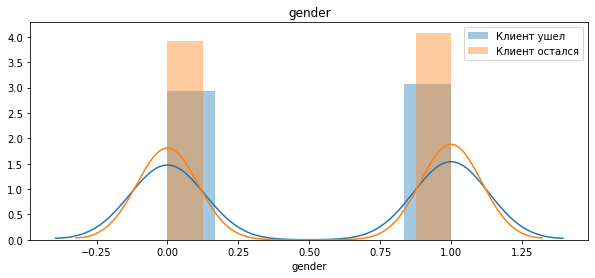

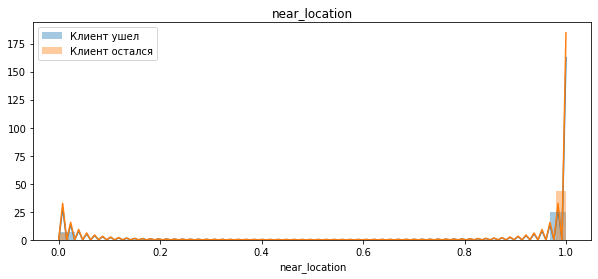

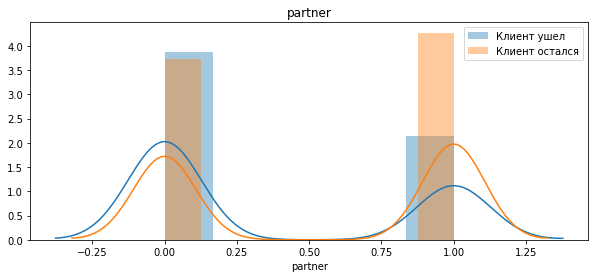

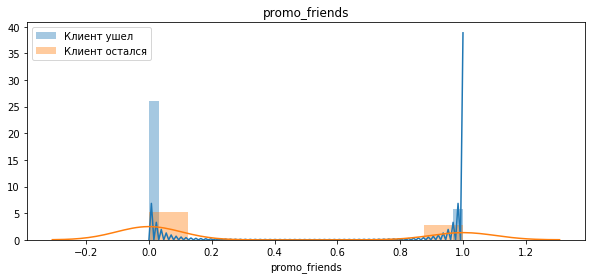

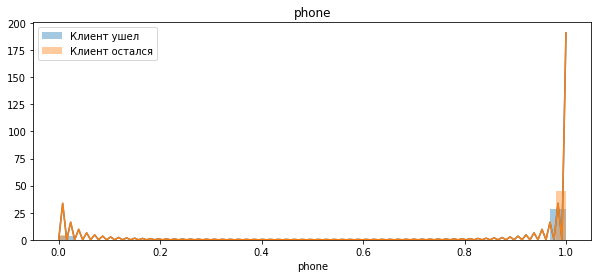

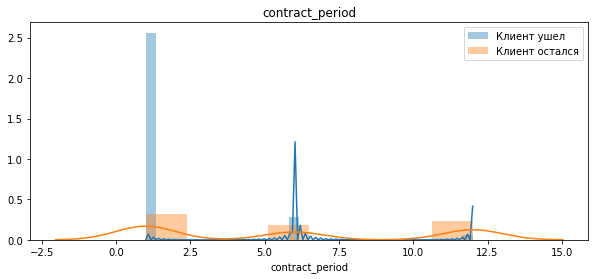

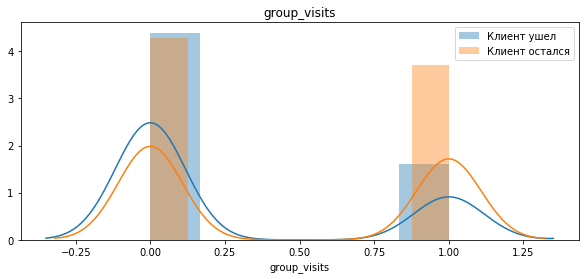

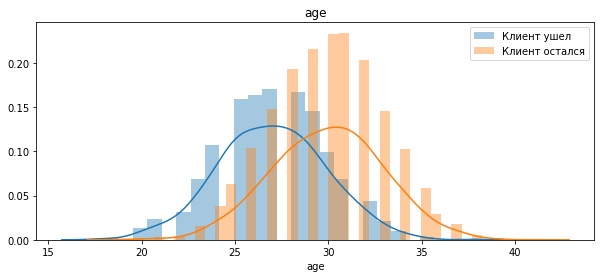

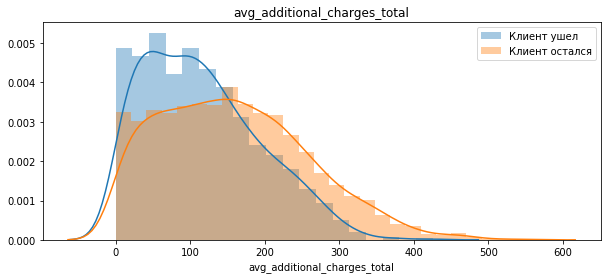

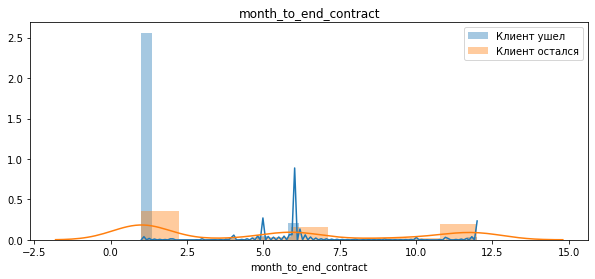

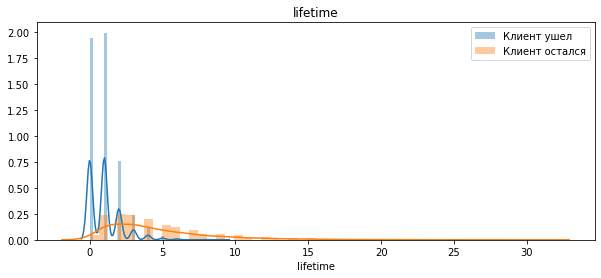

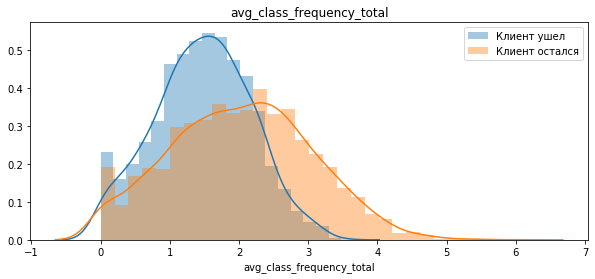

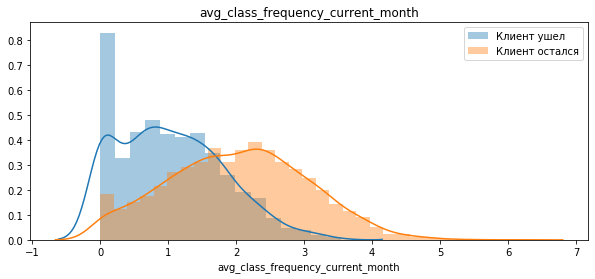

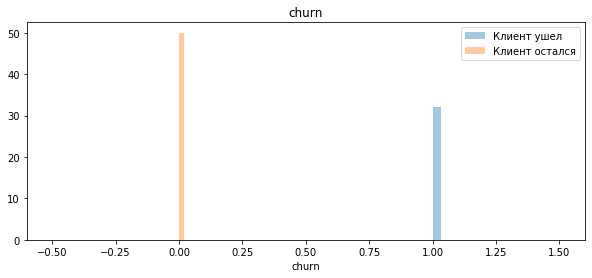

In [10]:
#построим графики по всем признакам

for column in fitness.columns: 
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.distplot(churn_clients[column])
    sns.distplot(non_churn_clients[column])
    plt.legend(['Клиент ушел', 'Клиент остался'])
    plt.show()

<b>Выводы: </b> <p>
- пол распределен так же, по 50%
- примерно 87% посетителей из тех, кто остался живет рядом, из тех кто ушел - 77%. Разница есть, но не слишком существенная.
- из тех, кто остался, 53% - сотрудники компаний-партнеров, при этом среди тех, кто ушел такие сотрудники составляют 36%
- из тех, кто пришел по приглашению друга, остались 35% и почти в два раза меньше их среди тех, кто ушел - 18%
- средняя длительность абонемента - для оставшихся - 5,7 месяцев, для ушедших - 1,7 месяца. 
- интересная зависимость от посещения групповых занятий: 46% из тех, кто остался их посещает, среди ушедших посетителей групповые зянятия посещали только 26%
- средний возраст клиентов примерно одинаковый в обеих группах: 29  лет среди оставшихся и 26 лет среди ушедших. Но при этом по графику видно, что рисунок ушедших смещается к более молодому возрасту, ваероятно, эта группа легче меняет клубы. Среди более страшей группы количство оставшихся выше. 
- средняя суммарная выручка от дополнительных услуг в клубе среди оставшихся выше, чем, среди ушедших - 158 и 115 у.е. соответственно.
- среднее количество месяцев до окончания контракта среди оставшихся - 5,2, среди ушедших - 1,6
- среднее время с момента первого обращения в центр среди оставшихся - 4,7, среди ушедших - менее 1 месяца
- средняя частота посещений в месяц с начала абонемента среди оставшихся - 2 раза, среди ушедших - 1,4
- средняя частота посещения клуба в неделю за предыдущий месяц среди оставшихся - 2 раза, среди ушедших - 1 

### Построим матрицу корреляций

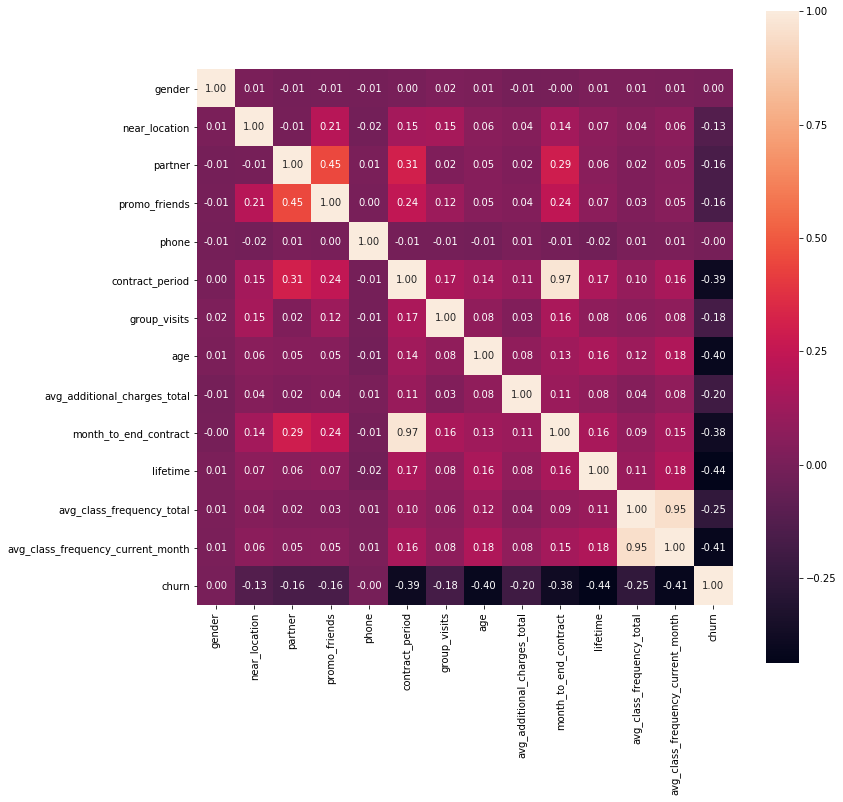

In [11]:
matrix = fitness.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(matrix, annot=True, fmt = '.2f', square=True)
plt.show()

<b>Выводы: </b> <p>
Из графика можем видеть существенные корреляции между двумя парами признаков: 
* month_to_end_contract и contract_period
* avg_class_frequency_total и avg_class_frequency_current_month

Можно выделить некоторыую зависимость между стобцами promo_friends и partner, а так же contract_period и partner. Как видим, лучшими посетителями в большей степени вероятности являются компании-партнеры. Их сотрудники покупают более длительные абонементы, а так же приводят в фитнес клуб своих друзей и знакомых.

<b> При этом существенной корреляции столбца 'churn' с данными оттока посетителей клуба с другими признаками на графике нет </b>

## Построим модель прогнозирования оттока клиентов

<b> Задачи: </b> <p>

1. Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце: разобьем данные на обучающую и валидационную выборку функцией train_test_split() 
<p><p>    
2. Обучим модель на train-выборке двумя способами:
* логистической регрессией,
* случайным лесом.
3. Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнить по ним модели. Какая модель показала себя лучше на основании метрик? Указать параметр random_state при разделении выборки и задании алгоритма.

### Логистическая регрессия

Для того, чтобы получить правильные результаты, нам необходимо удалить слишком коррелирующие признаки, которые мы выявили ранее.

In [12]:
#удаляем лишние признаки
fitness_new = fitness.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

In [13]:
#разделим данные на признаки (матрица X) и целевую переменную (y)
X = fitness_new.drop('churn', axis = 1)
y = fitness_new['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для нашей модели
lr_model = LogisticRegression(random_state = 0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [14]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

<b> Метрики логистической регрессии:

In [15]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
	F1: 0.80
	ROC_AUC: 0.95


### Случайный лес

In [16]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

<b> Метрики случайного леса:

In [17]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.78
	Recall: 0.77
	F1: 0.78
	ROC_AUC: 0.94


По метрике ROC_AUC обе модели выглядят хорошо, но засчет чуть более высоких показателей Precision, Recall и F1 линейная регрессия выглядит лучше, но разница не слишком большая

## Кластеризация клиентов

<b>Проведем кластеризацию клиентов без учета столбца с оттоком клиента:</b> <p>
1. Стандартизируем данные
2. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
3. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
4. Посмотрим средниезначения кластеров
5. Построим распределения признаков для кластеров
6. Для каждого полученного кластера посчитаем долю оттока (методом groupby())

In [18]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#в переменной linked сохранена таблица «связок» между объектами
linked = linkage(X_sc, method = 'ward') 

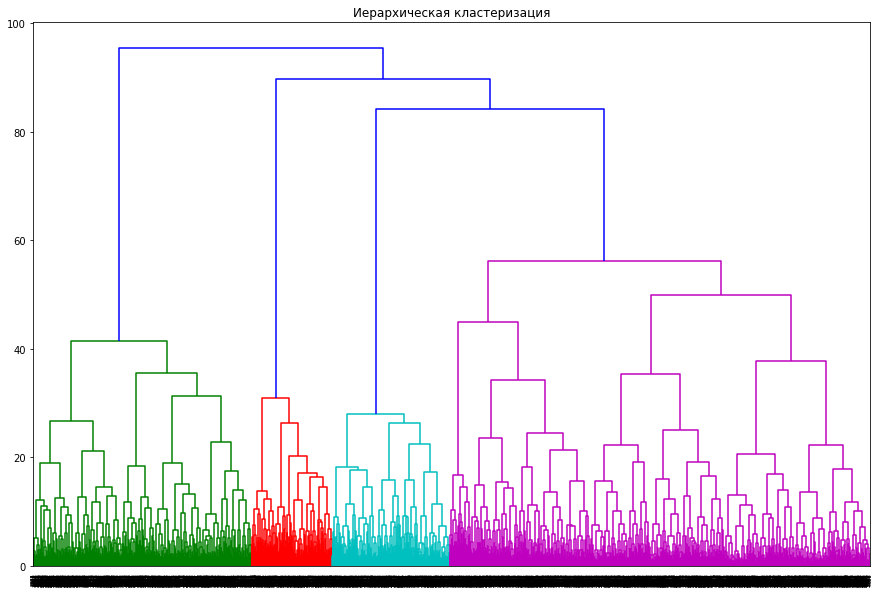

In [19]:
#строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Всего дендрограмма выделила 4 кластера

In [20]:
# задаём модель k_means с числом кластеров 5 (по заданию)
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)

fitness_new['cluster_km'] = labels
fitness_new.groupby(['cluster_km']).mean().T


cluster_km,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


<b> Выводы: </b> <p>
Кластер 0:  <p>
- Отток 26% - выше среднего 
- 86% клиентов из этого кластера живут рядом с клубом
- Клиенты из этого кластера не предоставляют телефоны для связи
- Средняя продолжительность абонемента - 4,7 месяцев
- 42% из низ посещают групповые занятия
<p><p> 
    
Кластер 1: <p>
- Отток 12% - самый устойчивый кластер посетителей  <p>
- 99% живут рядом с клубом
- 95% являются сотрудниками компаний-партнеров
- 89% из них привели друзья
- средний срок абонемента - 7,6 месяцев
- 45% посещают групповые занятия
- самая высокая средняя посещаемость - 1,97 раз в неделю
<p><p>
Кластер 2: <p>
- Отток 38% - высокий отток посетителей  <p>
- Все живут рядом с клубом
- 23% являются сотрудниками компаний-партнеров
- 5% из них привели друзья
- Средний срок абонемента - 2,8 месяцев
- Средний возвраст 28 лет
- Не посещают групповые занятия
<p><p>
Кластер 3: <p>
- Отток 20% - средний отток  <p>
- Все живут рядом с клубом
- 25% являются сотрудниками компаний-партнеров
- 7% из них привели друзья
- Средний срок абонемента - 4,5 месяцев
- Средний возвраст 29 лет
- Все посещают групповые занятия 
- Втораой кластер по посещаемости - в среднем 1,94 раз в неделю
<p><p>
Кластер 4: <p>
- Отток 39% - самый высокий отток  <p>
- Не живут рядом с клубом
- 48% являются сотрудниками компаний-партнеров
- 7% из них привели друзья
- Средний срок абонемента - 3 месяцев
- Средний возвраст 28 лет
- Групповые занятия посещают только 23%
- Реже всех посещают клуб - в среднем 1,7 раз в неделю     

<b> Построим гарфики для наглядности 

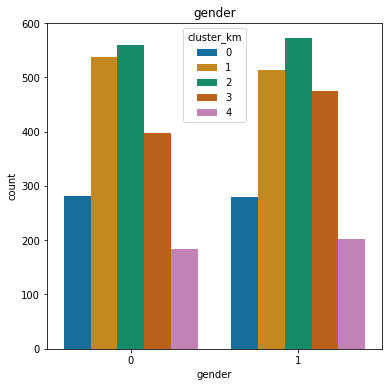

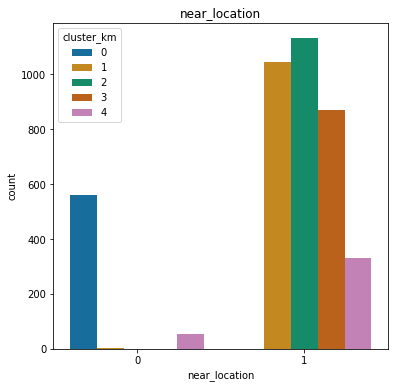

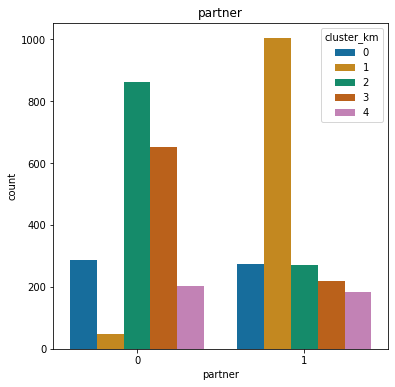

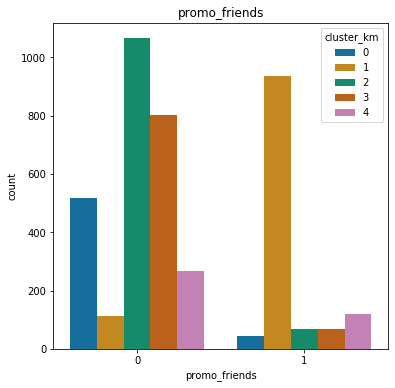

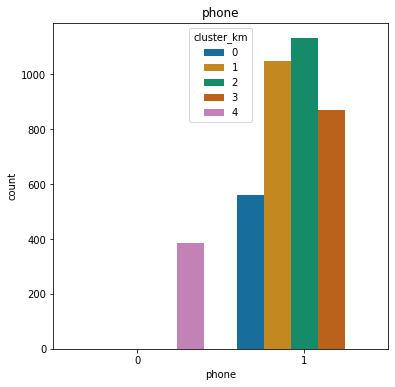

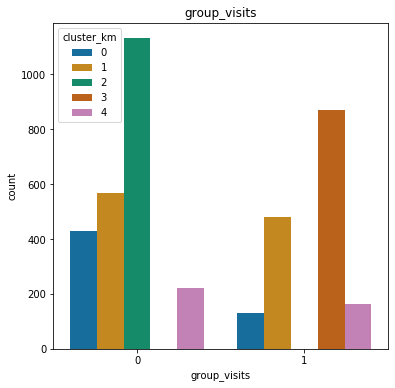

In [21]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(6, 6))
    sns.countplot(x = fitness_new[column], hue='cluster_km', data=fitness_new, palette='colorblind')
    plt.title(column)
    plt.show()

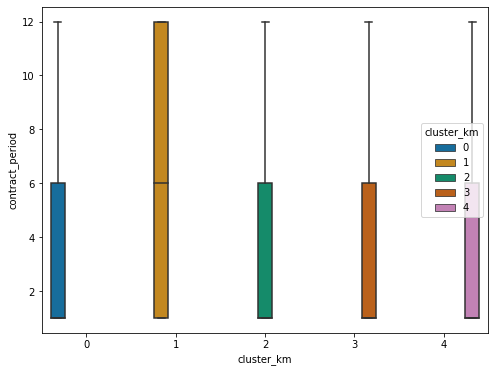

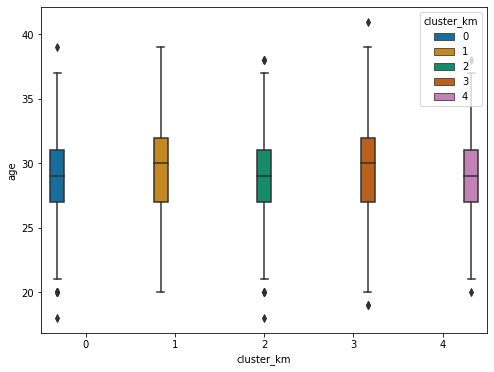

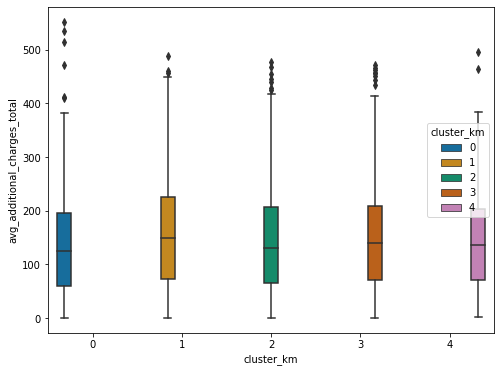

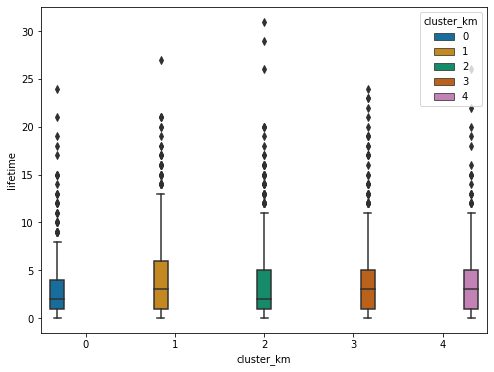

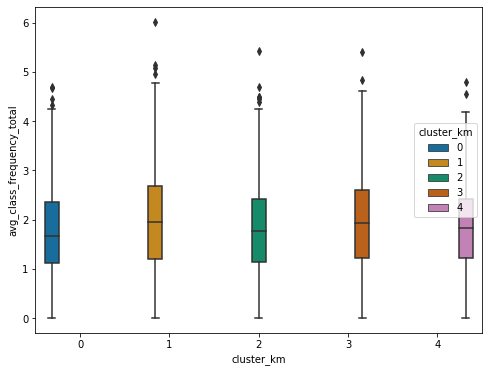

In [22]:
for column in ['contract_period', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x = 'cluster_km', y = fitness_new[column], data = fitness_new, hue='cluster_km', palette='colorblind')
    plt.show()

На графиках можно наглядно посмотреть распределние признаков по кластерам. По бинарным признакам выводы совпадают с теми, что мы сделали по таблице выше. По остальным стало наглядно видно распределение, например:
- У самого"положителььного" первого кластера не только средняя длительность контратка высокая, но и в целом распределение занчений  в высоком диапазоне, чего нет у остальных
- По возрасту так же видим, что у 1 и 3 кластера, распределение посетителей ближе к возврастной категории
- По затратам на дополнительные услуги так же 1 и 3 кластер немного выше на графике, чем остальные.
- По значениям lifetime так же видим, что этот показатель ниже у самой неблагополучной "нулевой" группы, а у 1 выше остальных
- По средней посещаемости так же выигрывает первый кластер. Самое небольшое распределение - так же у первой группы.



## Выводы

Таким образом, можно сделать выводы, что на посещаемость влияют в наибольшей степени следующие факторы:
- более старший возраст
- если посетителя привел друг
- посещение групповых занятий
- средняя продолжительность абонемента
- контракт с компанией-партнером


Мы так же моежм сделать интересный вывод, что дальнее расстояние до местарасположения клуба может способствовать оттоку посетителей (это видно по кластеру 0), но при этом, сама по себе близость клуба к своим клиентам не так сильно влияет на удержание клиентов, только в совокупности с другими факторами (например, по калстеру 2 у нас высокие показатели по билзости клуба, но, тем не менее, он на 2 месте по оттоку)

Хорошо влияет на удержание клиента регулярное посещение групповых занятий. вероятно, это в некоторой степени связано с общением с другими посетителями.

<b> Рекомендации:

1. Постараться увеличить привленчение посетителей на групповые занятия
2. Акцент на привлечение лучше делать на возраст от 29 лет и страше
3. Продумать акции на продажу абонементов на длительный, годовой срок.
4. Наиболее выгодно заключать контракты с компаниями, которые приводят своих сотрудников в клуб.
5. Стараться, привлекать посетителей интересными занятиями и удобным расписанием, чтобы посетителям было удобно регулярно ходить на одну и ту же тренировку - не мене 2х раз в неделю